# EM dataset

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path

import numpy as np
from lotr import A_FISH, DATASET_LOCATION, LotrExperiment
from lotr import plotting as pltltr
from lotr.analysis.pool_cell_info import get_pooled_cell_info
from lotr.em.core import MIDLINES
from lotr.em.loading import load_skeletons_from_zip
from lotr.result_logging import ResultsLogger
from lotr.utils import linear_regression
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_dilation
from tqdm import tqdm

logger = ResultsLogger()

COLS = pltltr.COLS

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_71167/3328008066.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_71167/3328008066.py:14: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


## Data loading

In [3]:
# Reference:
# Load the gad1b stack and the annotation from the IPN atlas:

from bg_atlasapi.core import Atlas

atlas = Atlas(DATASET_LOCATION.parent / "anatomy" / "ipn_zfish_0.5um_v1.8")

gad1b_stack = atlas.additional_references["gal4_gad1b"]


# Enlarge a bit the mask for the IPN (in the future we'll draw better masks):
mask = np.zeros((3, 3, 3)).astype(bool)
mask[:, 1, :] = True
annotation = binary_dilation(
    atlas.get_structure_mask("ipn") > 0, iterations=7, structure=mask
)
annotation_dipn = binary_dilation(
    atlas.get_structure_mask("dipn") > 0, iterations=7, structure=mask
)

In [6]:
# Load the EM and mirror neurons on one side:
em_path = DATASET_LOCATION.parent / "anatomy" / "aHB_dIPN.k.zip"

sel_neurons = load_skeletons_from_zip(em_path)

for n in sel_neurons:
    n.mirror = "right"

## Projections with line anatomy

In [7]:
from lotr import plotting as pltltr

COLS = pltltr.COLS

In [8]:
#  Specify axes limits over all dimensions:
bs = dict(frontal=(30, 180), vertical=(-4, 170), sagittal=(-50, 120))

plotter = pltltr.AtlasPlotter(
    atlas=atlas,
    structures=["ipn", "dipn"],
    mask_slices=dict(frontal=slice(0, 120)),
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
)

## Calculate centroids

In [9]:
centroids = []
for n in sel_neurons:
    centroids.append(
        [n.find_centroid_bifurcation(select=s) for s in ["dendrites", "axon"]]
    )

centroids = np.array(centroids)
norm_cm = centroids[:, 1, 2] - centroids[:, 1, 2].min()
norm_cm = norm_cm + 5
norm_cm = norm_cm / (norm_cm.max() + 0.01)

In [10]:
bs = dict(frontal=(30, 180), vertical=(-25, 170), sagittal=(-50, 120))
plotter = pltltr.AtlasPlotter(
    atlas=atlas,
    structures=["ipn", "dipn"],
    mask_slices=dict(frontal=slice(0, 120)),
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
)

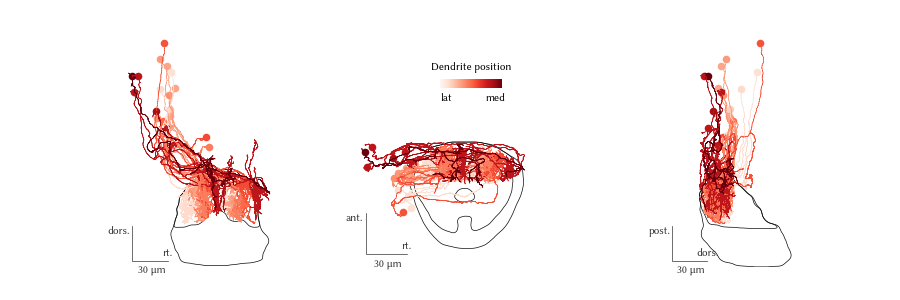

In [12]:
f, axs = plotter.generate_projection_plots()

lw = 0.5
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):
    if "bilat" in neuron.comments and "dipn" in neuron.comments.split("_"):
        main_c = cm.get_cmap("Reds")(c)
        plotter.plot_neurons(axs, neuron, c=main_c, lw=lw, rasterized=False)

fake_im = axs[0].scatter([], [], c=[], cmap="Reds")
pltltr.add_cbar(
    fake_im,
    axs[1],
    inset_loc=(0.425, 0.8, 0.3, 0.04),
    ticks=[0.1, 0.9],
    ticklabels=["lat", "med"],
    orientation="horizontal",
    title="Dendrite position",
    titlesize=8,
)

for i, (proj, pos) in enumerate(
    zip(plotter.space.sections, [(35, 165), (35, 110), (5, 165)])
):
    pltltr.add_anatomy_scalebar(
        axs[i], plane=proj, pos=pos, cartesian=True, equalize_axis=False, length=30,
    )
#f.savefig("/Users/luigipetrucco/Desktop/figures_cosyne/dipn_neurons_colcoded.pdf")
# pltltr.savefig("dipn_neurons_colcoded_allviews", folder="S15")

# Gif: sequence of neurons

In [ ]:
bs = dict(frontal=(50, 160), vertical=(70, 100), sagittal=(-50, 120))
plotter = pltltr.AtlasPlotter(
    atlas=atlas,
    structures=["ipn", "dipn"],
    mask_slices=dict(frontal=slice(0, 120)),
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
)

In [ ]:
dest_path = Path(r"/Users/luigipetrucco/Desktop/plotgif")

norm_cm = centroids[:, 1, 2] - centroids[:, 1, 2].min()
norm_cm = norm_cm + 15
norm_cm = norm_cm / (norm_cm.max() + 0.01)
idxs = np.argsort(norm_cm)
axlab = "frontal"
figsize = (6, 6)
lw = 2

for i_plot in tqdm(range(len(sel_neurons))):  #
    f, ax = plt.subplots(1, 1, figsize=figsize)
    plotter.plot_on_axis(ax, axlab, labels=False, title=False)
    for n, i in enumerate(idxs):
        plotter.plot_neuron_projection(
            ax,
            sel_neurons[i],
            axlab,
            c=pltltr.shift_lum(cm.get_cmap("Reds")(norm_cm[i]), 0.0),
            lw=lw,
            rasterized=True,
            alpha=int(n < i_plot) * 0.5,  # exclude some neurons
        )
    plotter.plot_neuron_projection(
        ax,
        sel_neurons[idxs[i_plot]],
        axlab,
        c=pltltr.shift_lum(cm.get_cmap("Reds")(norm_cm[idxs[i_plot]]), -0.0),
        lw=lw,
        rasterized=True,
    )
    ##  ax.axis("equal")
    f.savefig(dest_path / f"plot_{i_plot:02d}.png", dpi=600)
    plt.close()

f, ax = plt.subplots(1, 1, figsize=figsize)
axlab = "frontal"
plotter.plot_on_axis(ax, axlab, labels=False, title=False)
for i in idxs:
    plotter.plot_neuron_projection(
        ax,
        sel_neurons[i],
        axlab,
        c=cm.get_cmap("Reds")(norm_cm[i]),
        lw=lw,
        rasterized=True,
    )
f.savefig(dest_path / f"plot_{i_plot:02d}.png", dpi=600)
plt.close("all")

In [ ]:
sorted_traces = exp.traces[:, exp.hdn_indexes][:, np.argsort(exp.rpc_angles)]
# img_traces = ax_traces.imshow()
tofill = np.full(sorted_traces.shape, np.nan)
n = 500
tofill[:n, :] = sorted_traces[:n, :]

In [ ]:
f, ax = plt.subplots()
img_traces = plt.imshow(tofill.T, cmap="gray_r", aspect="auto", vmin=-1.5, vmax=1.5)

In [ ]:
plt.figure()
(sc,) = plt.fill([1, 2, 3], [2, 3, 0])

In [ ]:
sc.get_xy()#set_xy(np.array([[1, 2, 3], [2, 3, -1]]).T)

# Gif: activity propagation

In [ ]:
import matplotlib as mpl
from lotr import A_FISH, LotrExperiment
from lotr.analysis.activity_profile import resample_and_shift

n_bins = 100
exp = LotrExperiment(A_FISH)
sorted_traces = exp.traces[:, exp.hdn_indexes[np.argsort(exp.rpc_angles)]]
resamp, _ = resample_and_shift(exp, n_bins_resampling=n_bins)

In [ ]:
resamp_norm = (resamp.T - np.percentile(resamp, 2, axis=1)).T
resamp_norm[resamp_norm < 0] = 0
resamp_norm = (resamp_norm.T / np.percentile(resamp, 95, axis=1)).T
resamp_norm[resamp_norm > 1] = 1

In [ ]:
bs = dict(frontal=(20, 190), vertical=(70, 100), sagittal=(-50, 120))
plotter = pltltr.AtlasPlotter(
    atlas=atlas,
    structures=["ipn", "dipn"],
    mask_slices=dict(frontal=slice(0, 120)),
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
)

In [ ]:
f, axs = plotter.generate_projection_plots()
selection = "axon"
n_list = []
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):

    orig_side = "left"
    if neuron._coords_ipn[neuron.soma_idx, 2] > 115:
        orig_side = "right"

    for i_s, side in enumerate(["left", "right"]):
        # dest_subfold = dest_dir / side
        # dest_subfold.mkdir(exist_ok=True)

        neuron.mirror = side
        phase = np.pi * c * (1 - i_s * 2)
        main_c = COLS["phase"]((phase + np.pi) / (2 * np.pi))  # cm.get_cmap("Reds")(c)
        # plotter.plot_neurons(axs, neuron, c=main_c, lw=lw, rasterized=True)

        dendrites = neuron.generate_plotlines_from_skeleton(
            select="dendrites", space="ipn"
        )
        axon = neuron.generate_plotlines_from_skeleton(select="axon", space="ipn")

        trace_i = int(((n_bins - 1) * (phase + np.pi) / (2 * np.pi)))
        n_list.append(
            # dest_subfold / neuron.id,
            dict(
                dendrites=dendrites,
                axon=axon,
                soma=neuron.coords_ipn[neuron.soma_idx],
                orig_side=orig_side,
                phase=phase,
                norm_centroid_pos=c,
                phase_color=main_c,
                pseudo_activation=resamp_norm[:, trace_i],
            )
        )
        plotter.plot_neurons(
            axs, neuron, c=main_c, lw=lw, select=selection, soma_s=50, rasterized=False
        )
        # )
np.random.shuffle(n_list)
f.savefig(f"/Users/luigipetrucco/Desktop/figures_cosyne/dipn_phasecol_{selection}.pdf")

In [ ]:
f, axs = plotter.generate_projection_plots()

lw = 0.5
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):
    if "bilat" in neuron.comments and "dipn" in neuron.comments.split("_"):
        main_c = cm.get_cmap("Reds")(c)
        plotter.plot_neurons(axs, neuron, c=main_c, lw=lw, rasterized=False)

fake_im = axs[0].scatter([], [], c=[], cmap="Reds")
pltltr.add_cbar(
    fake_im,
    axs[1],
    inset_loc=(0.425, 0.8, 0.3, 0.04),
    ticks=[0.1, 0.9],
    ticklabels=["lat", "med"],
    orientation="horizontal",
    title="Dendrite position",
    titlesize=8,
)

for i, (proj, pos) in enumerate(
    zip(plotter.space.sections, [(35, 165), (35, 110), (5, 165)])
):
    pltltr.add_anatomy_scalebar(
        axs[i], plane=proj, pos=pos, cartesian=True, equalize_axis=False, length=30,
    )
# f.savefig("/Users/luigipetrucco/Desktop/figures_cosyne/dipn_neurons_colcoded.pdf")
# pltltr.savefig("dipn_neurons_colcoded_allviews", folder="S15")

## Reconstructed activity gif

In [ ]:
dest_path = Path(r"/Users/luigipetrucco/Desktop/activation_gif_axons")
dest_path.mkdir(exist_ok=True)

In [ ]:
for i, t in tqdm(list(enumerate(range(0, 5000, 15)))):
    # t = 0
    plt.figure(figsize=(7, 4))
    for n in n_list:
        for s, cmap, off in zip(
            ["dendrites", "axon",],
            [cm.get_cmap("Blues"), cm.get_cmap("Reds")],
            [0, -100],
        ):
            plt.plot(
                n[s][:, 2],
                -n[s][:, 1] + off,
                c=cmap(norm(1)),
                alpha=n["pseudo_activation"][t] * 0.4,
                lw=1,
            )
        plt.scatter(
            n["soma"][2],
            -n["soma"][0] + 100,
            color=dff_colmap(norm(1)),  # dff_colmap(norm(n["pseudo_activation"][t])),
            alpha=n["pseudo_activation"][t] * 0.7,
            s=50,
            lw=0,
        )
    plt.axis("equal")
    plt.axis("off")
    plt.savefig(dest_path / f"frame_{i}.png")
    plt.close("all")

In [ ]:
import os


def save():
    os.system(
        f"ffmpeg -r 1 -i {dest_path}/frame_*.png -vcodec mpeg4 -y {dest_path}/movie.mp4"
    )


save()

In [ ]:
import cv2

image_folder = "images"
video_name = "video.avi"

images = sorted([img for img in dest_path.glob("*.png")])
frame = cv2.imread(str(images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width, height))

for image in tqdm(images):
    video.write(cv2.imread(str(images)))

cv2.destroyAllWindows()
video.release()

In [ ]:
save()

In [ ]:
dest_path = Path(r"/Users/luigipetrucco/Desktop/plotgif")

norm_cm = centroids[:, 1, 2] - centroids[:, 1, 2].min()
norm_cm = norm_cm + 15
norm_cm = norm_cm / (norm_cm.max() + 0.01)
idxs = np.argsort(norm_cm)

for i_plot in tqdm(range(len(sel_neurons))):  #
    f, axs = plt.subplots(1, 2, figsize=(6.0, 4))
    for axlab, ax in zip(["frontal", "horizontal"], axs):
        plotter.plot_on_axis(ax, axlab)
        for n, i in enumerate(idxs):
            plotter.plot_neuron_projection(
                ax,
                sel_neurons[i],
                axlab,
                c=pltltr.shift_lum(cm.get_cmap("Reds")(norm_cm[i]), 0.2),
                lw=lw,
                rasterized=True,
                alpha=int(n < i_plot),  # exclude some neurons
            )
        plotter.plot_neuron_projection(
            ax,
            sel_neurons[idxs[i_plot]],
            axlab,
            c=pltltr.shift_lum(cm.get_cmap("Reds")(norm_cm[idxs[i_plot]]), -0.2),
            lw=lw,
            rasterized=True,
        )

    f.savefig(dest_path / f"plot_{i_plot}.png")
    plt.close()

f, axs = plt.subplots(1, 2, figsize=(6.0, 4))
for axlab, ax in zip(["frontal", "horizontal"], axs):
    plotter.plot_on_axis(ax, axlab)
    for i in idxs:
        plotter.plot_neuron_projection(
            ax,
            sel_neurons[i],
            axlab,
            c=cm.get_cmap("Reds")(norm_cm[i]),
            lw=lw,
            rasterized=True,
        )
f.savefig(dest_path / f"plot_{i_plot+1}.png")
plt.close("all")

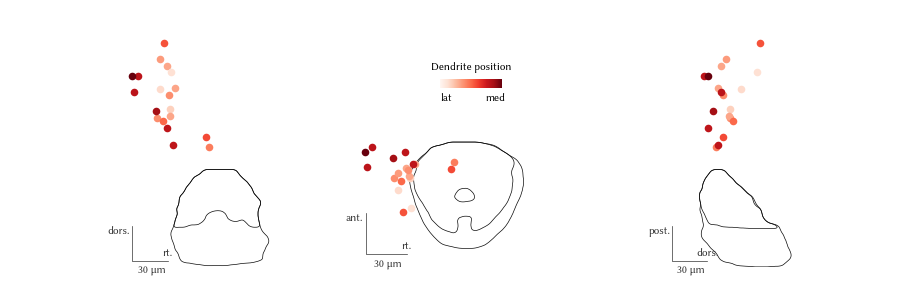

In [13]:
f, axs = plotter.generate_projection_plots()

lw = 0.5
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):
    if "bilat" in neuron.comments and "dipn" in neuron.comments.split("_"):
        main_c = cm.get_cmap("Reds")(c)
        plotter.plot_neurons(axs, neuron, c=main_c, lw=0, rasterized=True)

fake_im = axs[0].scatter([], [], c=[], cmap="Reds")
pltltr.add_cbar(
    fake_im,
    axs[1],
    inset_loc=(0.425, 0.8, 0.3, 0.04),
    ticks=[0.1, 0.9],
    ticklabels=["lat", "med"],
    orientation="horizontal",
    title="Dendrite position",
    titlesize=8,
)

for i, (proj, pos) in enumerate(
    zip(plotter.space.sections, [(35, 165), (35, 110), (5, 165)])
):
    pltltr.add_anatomy_scalebar(
        axs[i], plane=proj, pos=pos, cartesian=True, equalize_axis=False, length=30,
    )
pltltr.savefig("dipn_neurons_colcoded_allviews_somaonly", folder="S15")

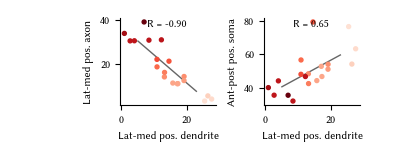

In [14]:
distances_from_midline = np.abs(centroids[:, :, 2] - MIDLINES["ipn"])

s = 8
f, axs = plt.subplots(
    1, 2, figsize=(4, 1.5), gridspec_kw=dict(bottom=0.3, left=0.3, wspace=0.5)
)
xline_lims = np.mean(distances_from_midline[:, 0]) + np.array(
    [np.std(distances_from_midline[:, 0]) * 1.2 * s for s in [-1, 1]]
)

soma_pos = np.zeros(len(sel_neurons))
for i, neuron in enumerate(sel_neurons):
    soma_pos[i] = neuron.coords_ipn[neuron.soma_idx, 0]

for i, (x, y) in enumerate(
    [
        (distances_from_midline[:, 0], distances_from_midline[:, 1]),
        (distances_from_midline[:, 0], soma_pos),
    ]
):
    axs[i].scatter(x, y, s=s, c=norm_cm, cmap="Reds", vmin=0, vmax=1)
    a, b = linear_regression(x, y)
    axs[i].plot(xline_lims, a + xline_lims * b, lw=1, c=".4", zorder=-10)
    ylims = axs[i].get_ylim()
    cc = np.corrcoef(x, y)[0, 1]
    axs[i].text(
        np.mean(xline_lims),
        ylims[1] - (ylims[1] - ylims[0]) * 0.1,
        f"R = {cc:0.2f}",
        ha="center",
    )

axs[0].set(xlabel="Lat-med pos. dendrite", ylabel="Lat-med pos. axon")
axs[1].set(xlabel="Lat-med pos. dendrite", ylabel="Ant-post pos. soma")

for ax in axs:
    pltltr.despine(ax)
pltltr.savefig("dipn_neurons_scatterplots")

In [ ]:
logger

In [ ]:
#  Specify axes limits over all dimensions:
bs = dict(frontal=(50, 160), vertical=(-4, 170), sagittal=(-50, 120))

plotter = pltltr.AtlasPlotter(
    atlas=atlas,
    structures=["ipn", "dipn"],
    mask_slices=dict(frontal=slice(0, 120)),
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
)

# Plot pairs

In [15]:
neurons_list_notmirr = load_skeletons_from_zip(em_path)

# Select neurons with projections internal to the dIPN:

sel_neurons_notmirr = [
    n
    for n in neurons_list_notmirr
    if "bilat" in n.comments.split("_") and "dipn" in n.comments.split("_")
]

In [16]:
sel_neurons_notmirr_dict.keys()

NameError: name 'sel_neurons_notmirr_dict' is not defined

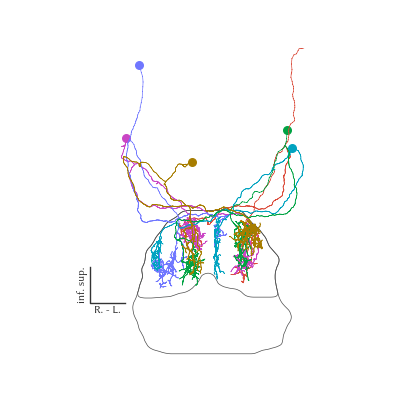

In [17]:
sel_neurons_notmirr_dict = {n.id: n for n in sel_neurons_notmirr}
cols = COLS["qualitative"]

off_x = 0
off_y = 0
s = 1.0
f, ax = plt.subplots(figsize=(4, 4))
"""
ax.imshow(
    gad1b_stack[20:170, :, :].max(0),
    origin="lower",
    cmap="gray_r",
    vmin=450,
    vmax=15000,
    extent=(0, (gad1b_stack.shape[2] / 2) * s, 0, (gad1b_stack.shape[1] / 2) * s),
)
"""
pltltr.plot_projection(
    annotation[:120, :, :],
    0,
    ax=ax,
    smooth_wnd=15,
    linewidth=0.5,
    fill=False,
    edgecolor=".3",
)
pltltr.plot_projection(
    annotation_dipn[:130, :, :],
    0,
    ax=ax,
    smooth_wnd=15,
    linewidth=0.5,
    fill=False,
    edgecolor=".3",
)

for i, neuron_id in enumerate(["c017", "p084", "c011", "p077", "c018", "p085"]):
    neuron = sel_neurons_notmirr_dict[neuron_id]
    if "bilat" in neuron.comments.split("_") and "dipn" in neuron.comments.split("_"):
        main_c = COLS["phase"](1 / 6 + i / 6)
        lines = neuron.generate_plotlines_from_skeleton(space="ipn", select="dendrites")
        (l,) = ax.plot(
            lines[:, 2], lines[:, 1], lw=0.5, c=pltltr.shift_lum(main_c, 0.0)
        )

        lines = neuron.generate_plotlines_from_skeleton(space="ipn", select="axon")
        (l,) = ax.plot(
            lines[:, 2], lines[:, 1], lw=0.5, c=pltltr.shift_lum(main_c, 0.0)
        )

        soma = neuron.coords_ipn[neuron.soma_idx, :]
        ax.scatter(soma[2], soma[1], s=30, color=pltltr.shift_lum(main_c, 0.0))
        ax.axis("equal")
        ax.set(ylim=(170, -4), xlim=(50, 160))

pltltr.despine(ax, "all")
pltltr.add_scalebar(
    ax, ylen=-20, xlen=20, ypos=140, xpos=40, xlabel="R. - L.", ylabel="inf. sup."
)
pltltr.savefig("dipn_pairs")

## Autocorrs

In [ ]:
from lotr.em.tracing_tree import find_bifurcations

all_centroids = []
for n in sel_neurons:
    all_centroids.append(
        np.concatenate(
            [
                n.get_coords("ipn")[find_bifurcations(n.edges_dict[s]), :][:, [0, 2]]
                for s in ["dendrites", "axon"]
            ]
        )
    )

In [ ]:
w = 130
h = 70
corrs = np.zeros((w, h, len(all_centroids)))

for n_i, neuron in enumerate(all_centroids):
    for i in range(neuron.shape[0]):
        focal = neuron[i, :]
        others = np.round(neuron - focal + np.array([h // 2, w // 2])).astype(int)
        others[others < 0] = 0
        others[others < 0] = 0
        others[others[:, 0] >= h, 0] = h - 1
        others[others[:, 1] >= w, 1] = w - 1
        corrs[others[:, 1], others[:, 0], n_i] += 1

In [ ]:
f, ax = plt.subplots(figsize=(3, 2), gridspec_kw=dict(left=0.2, bottom=0.2, right=0.85))
c = plt.imshow(
    gaussian_filter(corrs.sum(2).T, 1.5),
    extent=[-w // 2, w // 2, -h // 2, h // 2],
    cmap="Reds",
    vmin=1,
    vmax=200,
)
ax.set_xlabel("Dist. from focal node-\nfrontal ax. (μm)", ha="center")
ax.set_ylabel("Dist. from focal node-\nsagitt ax. (μm)", va="center")

ax.set(xticks=[-60, -30, 0, 30, 60], yticks=[-30, 0, 30])

pltltr.add_cbar(c, ax, inset_loc=(1.08, 0.0, 0.05, 0.5), ticks=[0, 100, 200])
pltltr.savefig("dist_from_focal_node")

In [ ]:
f, axs = plt.subplots(
    4, 5, figsize=(8, 5), gridspec_kw=dict(left=0.25, bottom=0.2, right=0.85)
)
for i in range(len(all_centroids)):
    ax = axs.flatten()[i]
    c = ax.imshow(
        gaussian_filter(corrs[:, :, i].T, 1.5),
        extent=[-w // 2, w // 2, -h // 2, h // 2],
        cmap="Reds",
        vmin=1,
        vmax=15,
    )
    pltltr.despine(ax)
    ax.set(xticks=[-60, -30, 0, 30, 60], yticks=[-30, 0, 30])
    ax.set_title(sel_neurons[i].id, loc="left", pad=-5)
    if i != 15:
        ax.set(xticklabels=[], yticklabels=[])
    else:
        ax.set_xlabel("Dist. from focal node-\nfrontal ax. (μm)", ha="center")
        ax.set_ylabel("Dist. from focal node-\nsagitt ax. (μm)", va="center")

[ax.axis("off") for ax in axs.flatten()[i + 1 :]]


# ax.set()

pltltr.add_cbar(c, ax, inset_loc=(1.4, 0.0, 0.08, 0.6), ticks=[0, 15], label="Count")
pltltr.savefig("dist_from_focal_node_all_n", folder="S15")

## Coords in MPI space

In [ ]:
pltltr.savefig("pairs")
from bg_atlasapi import BrainGlobeAtlas
from tifffile import imread

In [ ]:
mpin_atlas = BrainGlobeAtlas("mpin_zfish_1um")
mpin_atlas.annotation
# Annoying fixes required to deal with the Baier annotation mess. Will be cleaned in next version of the atlas.
mpin_atlas._annotation[[0, -1], :, :] = 0
mpin_atlas._annotation[:, [0, -1], :] = 0
mpin_atlas._annotation[:, :, [0, -1]] = 0
mpin_atlas._annotation[atlas._annotation == 0] = 15000
mpin_atlas.structures["root"]["id"] = 1

In [ ]:
import flammkuchen as fl
from lotr.data_preprocessing.anatomy import transform_points

matrices = fl.load(
    "/Volumes/Shared/experiments/E0044_spontaneous/gad1b/2p_anatomy/dendra/morphed anatomy files/xform_mat.h5"
)
mat = matrices["to_mpin"] @ np.linalg.inv(matrices["to_ipn"])

In [ ]:
coords = np.concatenate([neuron.coords_ipn[:, :] for neuron in sel_neurons_notmirr])
# trasf_coords = transform_points(coords, mat)

In [ ]:
#  Specify axes limits over all dimensions:
bs = dict(
    frontal=(0, mpin_atlas.shape[2] + 10),
    vertical=(0, mpin_atlas.shape[1] + 10),
    sagittal=(0, mpin_atlas.shape[0] + 10),
)

plotter = pltltr.AtlasPlotter(
    atlas=mpin_atlas,
    structures=["dorsal habenula", "root", "retina", "interpeduncular nucleus"],
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
    smooth_wnd=50,
)

In [ ]:
plt.figure()
plt.scatter(coords[:, 2], coords[:, 1])